# Visualizations

In [1]:
import os
import re
import numpy as np
from IPython.display import HTML
from itertools import groupby
import pickle

from Naive_HMM import unsupervised_HMM
import Naive_HMM_helper # import sample_sentence # sample_pair ?
import Overall_HMM_helper

from Visualization_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    visualize_sparsities,
    animate_emission
)

## Visualization of the dataset

We will be using Shakespeare's sonnets as our dataset. First, we visualize the entirety of his poems as a wordcloud:

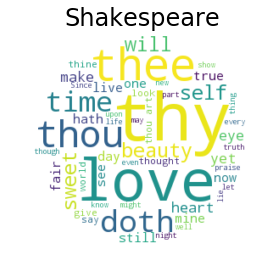

In [2]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare', max_words = 50)

## Training an HMM

Now we train an HMM on our dataset. We use 10 hidden states and train over 100 iterations:

In [3]:
shakespeare = open("data/shakespeare.txt", 'r')

poems = shakespeare.readlines()
split_at = "\n"
final_poems = [list(g)[1:] for k, g in groupby(poems, lambda x: x != split_at) if k]
poem_lengths = [len(poem) for poem in final_poems] 
bad_poems = np.where(np.array(poem_lengths)!= 14)[0]

final_poems = [final_poems[i] for i in np.delete(np.arange(len(final_poems)), bad_poems)]
final_poems = [''.join([line.strip(' ') for line in poem]) for poem in final_poems]
# token_map maps words to numbers
# tokenized_poems replaces the words in poems with their corresponding number
tokenized_poems, token_map = Overall_HMM_helper.parse_observations(final_poems)
token_map_r = Overall_HMM_helper.obs_map_reverser(token_map)
# THIS IS NASTY COPY PASTA - MAKE A FUNCTION FOR IT AT SOME POINT
# Helpful lists
# Syllables
syllable_file = open("data/Syllable_dictionary.txt", 'r')
syllables = syllable_file.readlines()
syllables = [x.split() for x in syllables]
syllable_dict = {}

# We choose to map words to tuples of lists
# the first list corresponds to the number of syllables if the word were at the end (E)
# the second list corresponds to the number of syllables the word can take anywhere
# E.g. "test": ['E1', '2', '3'] <-> "test": [([1], [2, 3])]
for syllable in syllables:
    word = re.sub(r'[^\w]', '', syllable[0])
    end_syllable_list = []
    regular_syllable_list = []
    for item in syllable[1:]:
        if item[0] == "E":
            end_syllable_list.append(int(item[1:]))
        else:
            regular_syllable_list.append(int(item))
    syllable_dict[word] = (end_syllable_list, regular_syllable_list)
tokenized_syllable_dict = {}
for key in syllable_dict.keys():
    # If the word in syllable_dict is in our token map, add it to our tokenized_syllable_dict
    try:
        tokenized_syllable_dict[token_map[key]] = syllable_dict[key]
    except KeyError:
        pass
# Flattens 3-dimensional list of list of lists to 2-dimensional list of lists
# (where each inner list corresponds to a line of a poem)
flattened_tokenized_poems = [val for sublist in tokenized_poems for val in sublist]
# flattened_poems = [val for sublist in tokenized_poems for val in sublist]

In [4]:
"""
# Train HMM
hmm = unsupervised_HMM(flattened_tokenized_poems, 16, 50)
print('Naive Sonnet:\n====================')
for i in range(14):
    print(Naive_HMM_helper.sample_sentence(hmm, token_map, \
                                           tokenized_syllable_dict, num_syllables=10))
"""
pickle_filename = 'hmm.p'

# Save HMM
# pickle.dump(hmm, open(pickle_filename, 'wb'))

# Load HMM
hmm = pickle.load(open(pickle_filename, 'rb'))

## Visualization of the sparsities of A and O

We can visualize the sparsities of the A and O matrices by treating the matrix entries as intensity values and showing them as images. What patterns do you notice?

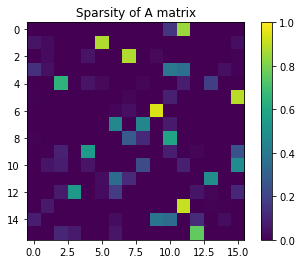

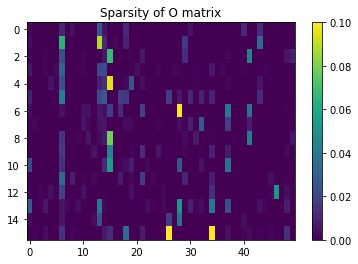

In [5]:
visualize_sparsities(hmm, O_max_cols=50)

## Visualizing the wordcloud of each state

Below, we visualize each state as a wordcloud by sampling a large emission from the state:

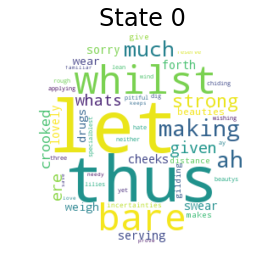

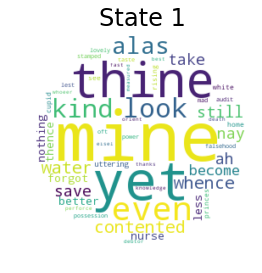

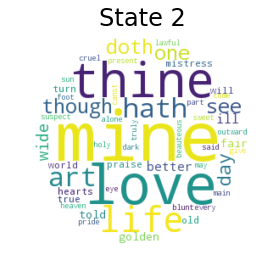

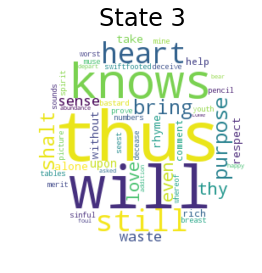

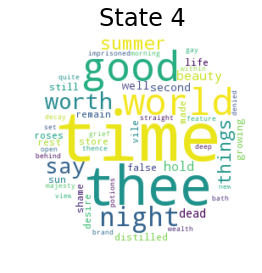

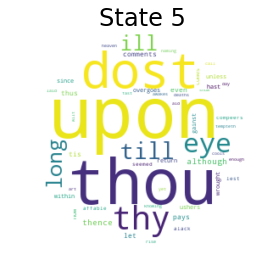

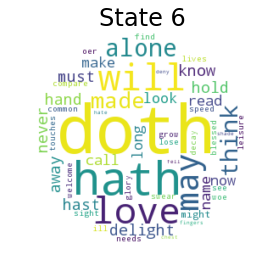

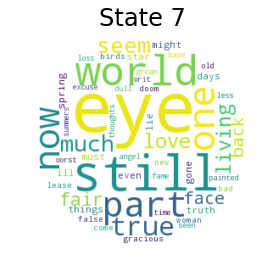

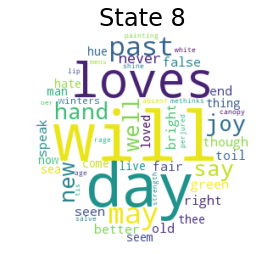

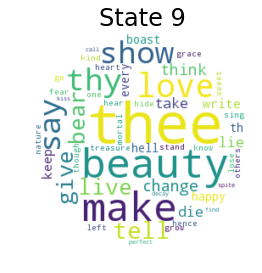

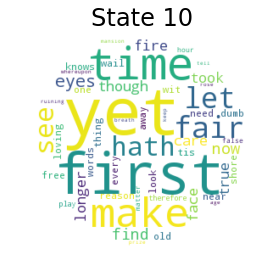

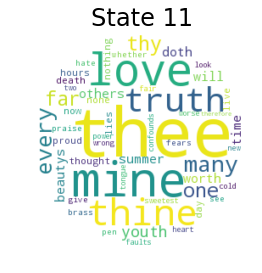

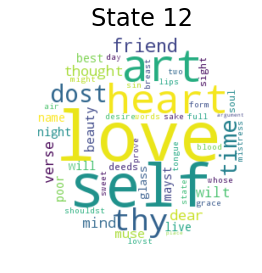

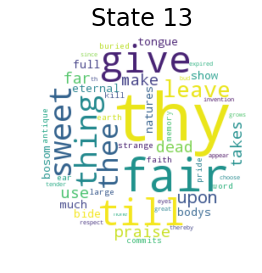

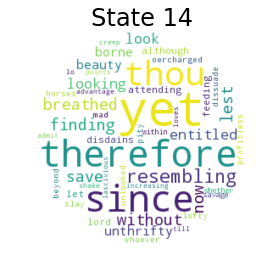

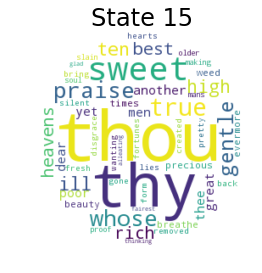

In [6]:
# Jank - add syllable_dict to hmm class to avoid having to pass it in
wordclouds = states_to_wordclouds(hmm, token_map, tokenized_syllable_dict)

## Visualizing the process of an HMM generating an emission

The visualization below shows how an HMM generates an emission. Each state is shown as a wordcloud on the plot, and transition probabilities between the states are shown as arrows. The darker an arrow, the higher the transition probability.

At every frame, a transition is taken and an observation is emitted from the new state. A red arrow indicates that the transition was just taken. If a transition stays at the same state, it is represented as an arrowhead on top of that state.

Use fullscreen for a better view of the process.

In [7]:
anim = animate_emission(hmm, token_map, tokenized_syllable_dict, M=8)
HTML(anim.to_html5_video())


Animating...


In [8]:
# https://vknight.org/unpeudemath/code/2015/11/15/Visualising-markov-chains.html
import networkx as nx  # For the magic
import matplotlib.pyplot as plt  # For plotting

2
2
2
3
4
2
1
3
3
4
6
3
5
2
4
4


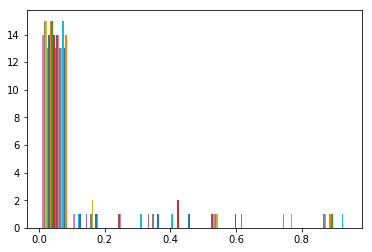

In [51]:
for k in range(hmm.L):
    print(sum(1 for i in hmm.A[k] if i > .05))
plt.hist(hmm.A)
plt.show()

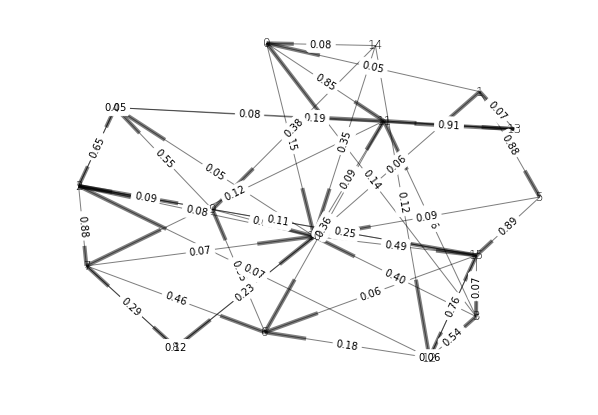

In [68]:
G = nx.MultiDiGraph()
labels={}
edge_labels={}
states = list(range(hmm.L))
threshold = .05
for origin_state in states:
    for destination_state in states:
        rate = hmm.A[origin_state][destination_state]
        if rate > threshold:
            G.add_edge(origin_state, destination_state, weight=rate, label="{:.02f}".format(rate))
            edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)
            
plt.clf()
plt.figure(figsize=(10,7))
node_size = 200
# pos = {state:list(state) for state in states}
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off');
plt.show()
# plt.savefig("hmm_graph.svg", bbox_inches='tight')
#nx.write_dot(G, 'mc.dot')
# nx.drawing.nx_agraph.write_dot(G, 'mc.dot')
#!neato -Tps -Goverlap=scale mc.dot -o mc.ps; convert mc.ps mc.png